In [11]:
# Pre-train용
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-8]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("output1.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Pre-trained.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = 0.8
train_dataset, val_dataset = train_test_split(dataset, test_size=1-train_size, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 옵티마이저 및 학습률 설정
# 기본 학습률 : 2e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 에폭 설정
epochs = 10

# 학습 루프
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[1]  # loss가 outputs의 두 번째 값입니다.
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}')

    # 모델 저장 및 평가
    model_save_path = f"Pre_train_epoch{epoch + 1}.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved for epoch {epoch + 1} at {model_save_path}")
    
    model.eval()
    val_accuracy = 0
    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()

    print(f'Validation Accuracy for epoch {epoch + 1}: {val_accuracy / len(val_dataloader)}')


X_train
 ['7/29/1966, nan, 999-91-3709, S99988287, X5601074X, Mrs., Celia938, Roberts511, nan, Mayert710, M, white, hispanic, F, Agawam  Massachusetts  US, 362 Pacocha Gateway Apt 1, Northborough, Massachusetts, Worcester County, 1532.0, 42.27341123, -71.63243239, 1166971.45, 13416.2, 4/20/1989, nan, 5cfda74f-b462-4c73-aa96-d90da4002f8a, 40055000.0, Chronic sinusitis (disorder), Body mass index 30+ - obesity (finding), Miscarriage in first trimester, Prediabetes, Hyperlipidemia, Nasal congestion (finding), Cough (finding), Sore throat symptom (finding), Sputum finding (finding), Muscle pain (finding), Joint pain (finding), Fever (finding)', '12/19/1965, 3/1/2020, 999-70-4989, S99948277, X2560575X, Mrs., Kala987, Prohaska837, nan, Gleason633, M, white, nonhispanic, F, Boston  Massachusetts  US, 310 Effertz Promenade, Gloucester, Massachusetts, Essex County, 1930.0, 42.63072986, -70.6443488, 1229943.52, 20003.74, 2/12/1984, nan, 3fc7077f-903c-4601-8078-a016e9b5a630, 59621000.0, Hypertens

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\MCC\anaconda3\envs\biotf\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to 

True
Epoch 1/10, Average Training Loss: 0.3671693565595038
Model saved for epoch 1 at Pre_train_epoch1.pt
Validation Accuracy for epoch 1: 0.884929906542056
Epoch 2/10, Average Training Loss: 0.320084329764468
Model saved for epoch 2 at Pre_train_epoch2.pt
Validation Accuracy for epoch 2: 0.883427903871829
Epoch 3/10, Average Training Loss: 0.31441075814791686
Model saved for epoch 3 at Pre_train_epoch3.pt
Validation Accuracy for epoch 3: 0.8841789052069426
Epoch 4/10, Average Training Loss: 0.3108887806219954
Model saved for epoch 4 at Pre_train_epoch4.pt
Validation Accuracy for epoch 4: 0.8841789052069426
Epoch 5/10, Average Training Loss: 0.3103741247539229
Model saved for epoch 5 at Pre_train_epoch5.pt
Validation Accuracy for epoch 5: 0.884929906542056
Epoch 6/10, Average Training Loss: 0.30494501469700547
Model saved for epoch 6 at Pre_train_epoch6.pt
Validation Accuracy for epoch 6: 0.883427903871829
Epoch 7/10, Average Training Loss: 0.2898066947018037
Model saved for epoch 7 at

In [50]:
# Fine-tune용
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-8]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("output3.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 불러오는 경로
model_path = "Pre_train_epoch10.pt"
# 모델 저장경로
model_path2 = "Fine-tuned.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = 0.8
train_dataset, val_dataset = train_test_split(dataset, test_size=1-train_size, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 옵티마이저 및 학습률 설정
# 기본 학습률 : 2e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)

# 에폭 설정
epochs = 10

# 학습 루프
hidden_states_list = []  # 모든 에폭에 대한 hidden state를 저장할 리스트
# 학습 루프
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[1]  # loss가 outputs의 두 번째 값입니다.
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}')

    # 모델 저장 및 평가
    model_save_path = f"Fine_tuned_epoch{epoch + 1}.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved for epoch {epoch + 1} at {model_save_path}")
    
    model.eval()
    val_accuracy = 0
    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()

    print(f'Validation Accuracy for epoch {epoch + 1}: {val_accuracy / len(val_dataloader)}')


X_train
 ['11/6/2011, nan, 999-81-9641, nan, nan, nan, Mack300, Halvorson124, nan, nan, nan, asian, nonhispanic, M, Avon  Massachusetts  US, 617 Hane Corner Unit 24, New Bedford, Massachusetts, Bristol County, 2743.0, 41.5103414, -70.9350167, 26475.3, 2679.84, 12/29/2019, 1/12/2020, 566f4d11-728e-49c2-8954-d17fedd7037b, 444814009.0, Viral sinusitis (disorder), Nasal congestion (finding), Cough (finding), Fever (finding), Loss of taste (finding)', '3/3/2000, nan, 999-39-4367, S99951818, X24980388X, Ms., Renee555, Blanda868, nan, nan, nan, white, nonhispanic, F, Natick  Massachusetts  US, 176 Dicki Highlands, Salisbury, Massachusetts, Essex County, nan, 42.80175139, -70.84150456, 538129.79, 2975.64, 4/27/2018, nan, c6f413a4-eb4a-4d1f-ad1a-61585fad9b2e, 59621000.0, Hypertension, Sputum finding (finding), Fever (finding), Normal pregnancy', '7/27/1951, 8/16/2018, 999-92-8207, S99933636, X43360252X, Mrs., Kristin64, Mann644, JD, Price929, M, white, nonhispanic, F, Worcester  Massachusetts  

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Pre-train model loaded.


C:\Users\MCC\anaconda3\envs\biotf\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


True
Epoch 1/10, Average Training Loss: 0.36177403558560506
Model saved for epoch 1 at Fine_tuned_epoch1.pt
Validation Accuracy for epoch 1: 0.8891129032258065
Epoch 2/10, Average Training Loss: 0.31443726943760386
Model saved for epoch 2 at Fine_tuned_epoch2.pt
Validation Accuracy for epoch 2: 0.8879928315412187
Epoch 3/10, Average Training Loss: 0.30399539108138257
Model saved for epoch 3 at Fine_tuned_epoch3.pt
Validation Accuracy for epoch 3: 0.8895609318996416
Epoch 4/10, Average Training Loss: 0.2997790468417532
Model saved for epoch 4 at Fine_tuned_epoch4.pt
Validation Accuracy for epoch 4: 0.8911290322580645
Epoch 5/10, Average Training Loss: 0.2947152891779334
Model saved for epoch 5 at Fine_tuned_epoch5.pt
Validation Accuracy for epoch 5: 0.8859767025089605
Epoch 6/10, Average Training Loss: 0.2923556942818308
Model saved for epoch 6 at Fine_tuned_epoch6.pt
Validation Accuracy for epoch 6: 0.8911290322580645
Epoch 7/10, Average Training Loss: 0.2918317484843537
Model saved fo

In [16]:
# 데이터 랜덤분할(500/500/250)
import pandas as pd
import numpy as np

def sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500):
    # CSV 파일을 읽어옵니다.
    data = pd.read_csv(input_file)
    
    # 데이터를 랜덤하게 샘플링합니다.
    sampled_data_750 = data.sample(n=n_500, random_state=42)
    
    # 첫 250개 데이터를 output_file_500과 output_file_100에 순서대로 삽입합니다.
    first_250 = sampled_data_750[:250]
    first_250.to_csv(output_file_500, index=False)
    first_250.to_csv(output_file_100, index=False)
    
    # 나머지 500개 데이터를 절반으로 나누어 각각 output_file_500과 output_file_100에 추가합니다.
    remaining_500 = sampled_data_750[250:]
    split_idx = len(remaining_500) // 2
    second_250_500 = remaining_500[:split_idx]
    second_250_100 = remaining_500[split_idx:]
    
    # 파일에 추가합니다.
    second_250_500.to_csv(output_file_500, mode='a', header=False, index=False)
    second_250_100.to_csv(output_file_100, mode='a', header=False, index=False)

# 입력 CSV 파일 경로
input_file = "output6.csv"

# 출력 CSV 파일 경로
output_file_500 = "random_500_D.csv"
output_file_100 = "random_500_C.csv"

# 랜덤하게 추출할 데이터 개수
n_500 = 750

# 함수 호출
sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500)



In [36]:
# 데이터 랜덤분할(300/500)
import pandas as pd

def sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500):
    # CSV 파일을 읽어옵니다.
    data = pd.read_csv(input_file)
    
    # 데이터를 랜덤하게 샘플링합니다.
    sampled_data_500 = data.sample(n=n_500, random_state=42)
    
    # 샘플링된 500개의 데이터를 CSV 파일로 내보냅니다.
    sampled_data_500.to_csv(output_file_500, index=False)
    
    # sampled_data_500에서 첫 100개의 데이터를 선택합니다.
    sampled_data_100 = sampled_data_500.head(300)
    
    # 선택된 첫 100개의 데이터를 CSV 파일로 내보냅니다.
    sampled_data_100.to_csv(output_file_100, index=False)

# 입력 CSV 파일 경로
input_file = "output6.csv"

# 출력 CSV 파일 경로
output_file_500 = "random_500.csv"
output_file_100 = "random_300.csv"

# 랜덤하게 추출할 데이터 개수
n_500 = 500

# 함수 호출
sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500)


In [62]:
# smashed data 생성 (500/server side)
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-6]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("random_500.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Pre_train_epoch10.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 모델 평가
model.eval()
val_accuracy = 0
hidden_states_list = []  # 평가할 때 hidden state를 저장할 리스트
for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()
    # hidden state를 저장합니다.
    hidden_states = outputs[2]
    hidden_states_list.append(hidden_states)
hidden_states_concat = torch.cat(hidden_states_list, dim=0)
hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
hidden_states_df = pd.DataFrame(hidden_states_concat)
hidden_states_df.to_csv("Dictionary_smashed_data.csv", index=False)

print(f'Validation Accuracy: {val_accuracy / len(dataloader)}')


X_train
 ['6/6/1971, nan, 999-71-5643, S99989143, X60757569X, Mr., Tracy345, Skiles927, nan, nan, M, white, nonhispanic, M, Marblehead  Massachusetts  US, 884 Auer Annex, Uxbridge, Massachusetts, Worcester County, nan, 42.10399442, -71.60337809, 1307003.54, 4997.12, 6/5/1974, nan, 5921ab74-99b6-49c9-a7d3-ad8349070ca8, 128613002.0, Seizure disorder, History of single seizure (situation), Hypertension, Body mass index 30+ - obesity (finding), Cough (finding), Sore throat symptom (finding), Viral sinusitis (disorder)', '10/28/1915, 3/3/1990, 999-77-6721, S99996606, X31277871X, Mrs., Londa304, Hessel84, nan, Weimann465, M, white, nonhispanic, F, Somerville  Massachusetts  US, 136 Ratke Manor, Dighton, Massachusetts, Bristol County, nan, 41.81765972, -71.18273423, 1416726.1, 356060.14, 12/21/1933, nan, e9e9254b-75fb-4c28-8694-4ac7c5d8f076, 59621000.0, Hypertension, Cardiac Arrest, History of cardiac arrest (situation), Prediabetes, Anemia (disorder), Smokes tobacco daily, Atrial Fibrillatio

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Pre-train model loaded.


C:\Users\MCC\anaconda3\envs\biotf\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


True
Validation Accuracy: 0.884765625


In [72]:
# smashed data 생성 (100/client side)
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-6]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("random_300.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Fine_tuned_epoch10.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 모델 평가
model.eval()
val_accuracy = 0
hidden_states_list = []  # 평가할 때 hidden state를 저장할 리스트
for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()
    # hidden state를 저장합니다.
    hidden_states = outputs[2]
    hidden_states_list.append(hidden_states)
hidden_states_concat = torch.cat(hidden_states_list, dim=0)
hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
hidden_states_df = pd.DataFrame(hidden_states_concat)
hidden_states_df.to_csv("Client_smashed_data_epoch10.csv", index=False)

print(f'Validation Accuracy: {val_accuracy / len(dataloader)}')


X_train
 ['6/6/1971, nan, 999-71-5643, S99989143, X60757569X, Mr., Tracy345, Skiles927, nan, nan, M, white, nonhispanic, M, Marblehead  Massachusetts  US, 884 Auer Annex, Uxbridge, Massachusetts, Worcester County, nan, 42.10399442, -71.60337809, 1307003.54, 4997.12, 6/5/1974, nan, 5921ab74-99b6-49c9-a7d3-ad8349070ca8, 128613002.0, Seizure disorder, History of single seizure (situation), Hypertension, Body mass index 30+ - obesity (finding), Cough (finding), Sore throat symptom (finding), Viral sinusitis (disorder)', '10/28/1915, 3/3/1990, 999-77-6721, S99996606, X31277871X, Mrs., Londa304, Hessel84, nan, Weimann465, M, white, nonhispanic, F, Somerville  Massachusetts  US, 136 Ratke Manor, Dighton, Massachusetts, Bristol County, nan, 41.81765972, -71.18273423, 1416726.1, 356060.14, 12/21/1933, nan, e9e9254b-75fb-4c28-8694-4ac7c5d8f076, 59621000.0, Hypertension, Cardiac Arrest, History of cardiac arrest (situation), Prediabetes, Anemia (disorder), Smokes tobacco daily, Atrial Fibrillatio

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Pre-train model loaded.
True
Validation Accuracy: 0.9067982456140351


In [73]:
# 유클리드 거리 유사도
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n=5):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 원본 파일을 읽어옵니다.
    original_client_data = pd.read_csv(original_file_client)
    original_dictionary_data = pd.read_csv(original_file_dictionary)
    
    # 데이터 포인트 간의 유클리드 거리를 계산합니다.
    distances = euclidean_distances(client_data.values, dictionary_data.values)
    
    # Top@n 유사도를 찾습니다.
    topn_similarities = np.argsort(distances, axis=1)[:, :n]
    topn_values = np.sort(distances, axis=1)[:, :n]
    
    # 모든 결과를 출력하고 정확도를 계산합니다.
    successful_distances = []
    unsuccessful_distances = []
    successes = 0
    success_indices = []  # 성공한 인덱스를 저장할 리스트
    success_ranks_count = {rank: 0 for rank in range(1, n+1)}  # 각 성공한 서버 측 랭크의 수를 저장할 딕셔너리
    for i, (indices, scores) in enumerate(zip(topn_similarities, topn_values)):
        """print(f"\nTop {n} inferences for client {i + 1}:")"""
        for rank, (idx, score) in enumerate(zip(indices, scores), 1):
            """print(f"Server {idx + 1} with distance {score}")"""
            if original_client_data.iloc[i].equals(original_dictionary_data.iloc[idx]):
                successes += 1
                successful_distances.append(score)
                success_indices.append((i + 1, rank))  # 성공한 인덱스를 추가
                success_ranks_count[rank] += 1  # 해당 랭크의 수를 증가시킴
            else:
                unsuccessful_distances.append(score)
        if successes == 0:
            print("No successful match found.")
    
    # 정확도 계산
    accuracy = successes / len(client_data)
    
    # 성공적으로 일치하는 데이터 포인트와 클라이언트 데이터 포인트, 그리고 일치하지 않는 데이터 포인트와 클라이언트 데이터 포인트 간의 평균 거리를 계산합니다.
    successful_mean_distance = np.mean(successful_distances)
    unsuccessful_mean_distance = np.mean(unsuccessful_distances)
    
    # 평균 거리의 분산 계산
    successful_distance_variance = np.var(successful_distances)
    unsuccessful_distance_variance = np.var(unsuccessful_distances)
    
    return accuracy, successful_mean_distance, unsuccessful_mean_distance, success_indices, successful_distance_variance, unsuccessful_distance_variance, success_ranks_count

# 변환된 파일 경로
dictionary_file = "Dictionary_smashed_data.csv"

# 원본 파일 경로
original_file_client = "random_300.csv"
original_file_dictionary = "random_500.csv"

# Top n 설정
n = 5

# 정확도 계산 및 평균 거리 계산
for i in range(1, 11):
    client_file = f'Client_smashed_data_epoch{i}.csv'
    accuracy, successful_mean_distance, unsuccessful_mean_distance, success_indices, successful_distance_variance, unsuccessful_distance_variance, success_ranks_count = calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n)

    print("\nFor file:", client_file)
    print("Accuracy:", accuracy)
    print("Successful Mean Distance:", successful_mean_distance)
    print("Unsuccessful Mean Distance:", unsuccessful_mean_distance)

    # 분산 출력
    print("Successful Distance Variance:", successful_distance_variance)
    print("Unsuccessful Distance Variance:", unsuccessful_distance_variance)

    # 성공한 인덱스들을 출력합니다.
    print("Success Indices:", success_indices)

    # 각 성공한 서버 측 랭크의 수를 출력합니다.
    print("Success Ranks Count:")
    for rank, count in success_ranks_count.items():
        print(f"Rank {rank}: {count} successes")



For file: Client_smashed_data_epoch1.csv
Accuracy: 1.0
Successful Mean Distance: 2.5438276577984817
Unsuccessful Mean Distance: 4.752387982648165
Successful Distance Variance: 0.3913100377899218
Unsuccessful Distance Variance: 0.9184424409806703
Success Indices: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1


For file: Client_smashed_data_epoch4.csv
Accuracy: 0.97
Successful Mean Distance: 3.7721809052998925
Unsuccessful Mean Distance: 5.255876781964985
Successful Distance Variance: 0.7664979070345245
Unsuccessful Distance Variance: 0.8818015841531784
Success Indices: [(1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 5), (51, 1), (52, 2), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 4), (79, 1), (80, 1), (81, 1), (83, 1), (84, 1), (85, 


For file: Client_smashed_data_epoch7.csv
Accuracy: 0.9433333333333334
Successful Mean Distance: 3.7758467261400006
Unsuccessful Mean Distance: 5.186008885027237
Successful Distance Variance: 0.8047412555404886
Unsuccessful Distance Variance: 0.8930949015315061
Success Indices: [(1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (79, 1), (80, 3), (81, 1), (83, 1), (84, 1), 


For file: Client_smashed_data_epoch10.csv
Accuracy: 0.7966666666666666
Successful Mean Distance: 4.227534181175542
Unsuccessful Mean Distance: 5.476350256029426
Successful Distance Variance: 1.0794834746356072
Unsuccessful Distance Variance: 0.8850476238873897
Success Indices: [(1, 1), (2, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 1), (20, 1), (21, 3), (22, 1), (23, 4), (24, 1), (25, 3), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (36, 1), (37, 1), (38, 4), (40, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 1), (48, 3), (51, 1), (52, 1), (53, 1), (54, 1), (56, 1), (57, 1), (58, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (79, 1), (80, 4), (81, 1), (83, 1), (84, 1), (85, 5), (86, 4), (87, 1), (89, 5), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 1)

In [74]:
# 코사인 유사도
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_accuracy_and_similarity(client_file, dictionary_file, original_file_client, original_file_dictionary, n=5):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 원본 파일을 읽어옵니다.
    original_client_data = pd.read_csv(original_file_client)
    original_dictionary_data = pd.read_csv(original_file_dictionary)
    
    # 데이터 포인트 간의 코사인 유사도를 계산합니다.
    similarities = cosine_similarity(client_data.values, dictionary_data.values)
    
    # Top@n 유사도를 찾습니다.
    topn_similarities = np.argsort(similarities, axis=1)[:, :-n-1:-1]  # 역순으로 정렬하여 상위 n개를 얻습니다.
    topn_values = -np.sort(-similarities, axis=1)[:, :-n-1:-1]  # 역순으로 정렬하여 상위 n개의 값만 얻습니다.
    
    # 모든 결과를 출력하고 정확도를 계산합니다.
    successful_distances = []
    unsuccessful_distances = []
    successes = 0
    success_indices = []  # 성공한 인덱스를 저장할 리스트
    for i, (indices, scores) in enumerate(zip(topn_similarities, topn_values)):
        """print(f"\nTop {n} inferences for client {i + 1}:")"""
        for rank, (idx, score) in enumerate(zip(indices, scores), 1):
            """print(f"Server {idx + 1} with similarity score {score}")"""
            if original_client_data.iloc[i].equals(original_dictionary_data.iloc[idx]):
                successes += 1
                successful_distances.append(score)
                success_indices.append((i + 1, rank))  # 성공한 인덱스를 추가
            else:
                unsuccessful_distances.append(score)
        if successes == 0:
            print("No successful match found.")
    
    # 정확도 계산
    accuracy = successes / len(client_data)
    
    # 성공적으로 일치하는 데이터 포인트와 클라이언트 데이터 포인트, 그리고 일치하지 않는 데이터 포인트와 클라이언트 데이터 포인트 간의 평균 유사도를 계산합니다.
    successful_mean_similarity = np.mean(successful_distances)
    unsuccessful_mean_similarity = np.mean(unsuccessful_distances)
    
    # 유사도의 분산 계산
    successful_similarity_variance = np.var(successful_distances)
    unsuccessful_similarity_variance = np.var(unsuccessful_distances)
    
    return accuracy, successful_mean_similarity, unsuccessful_mean_similarity, success_indices, successful_similarity_variance, unsuccessful_similarity_variance

# 변환된 파일 경로
#client_file = "Client_smashed_data_epoch10.csv"
dictionary_file = "Dictionary_smashed_data.csv"

# 원본 파일 경로
original_file_client = "random_300.csv"
original_file_dictionary = "random_500.csv"

# Top n 설정
n = 5

# 정확도 계산 및 평균 유사도 계산
for i in range(1, 11):
    client_file = f'Client_smashed_data_epoch{i}.csv'
    accuracy, successful_mean_similarity, unsuccessful_mean_similarity, success_indices, successful_similarity_variance, unsuccessful_similarity_variance = calculate_accuracy_and_similarity(client_file, dictionary_file, original_file_client, original_file_dictionary, n)

    print("\nAccuracy:", accuracy)
    print("Successful Mean Similarity:", successful_mean_similarity)
    print("Unsuccessful Mean Similarity:", unsuccessful_mean_similarity)

    # 분산 출력
    print("Successful Similarity Variance:", successful_similarity_variance)
    print("Unsuccessful Similarity Variance:", unsuccessful_similarity_variance)

    # 성공한 인덱스들을 출력합니다.
    print("Success Indices:", success_indices)



Accuracy: 1.0
Successful Mean Similarity: 0.5832581604617318
Unsuccessful Mean Similarity: 0.6006523540635847
Successful Similarity Variance: 0.0012225691791490979
Unsuccessful Similarity Variance: 0.0012625286762643782
Success Indices: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 


Accuracy: 0.97
Successful Mean Similarity: 0.5886010819282088
Unsuccessful Mean Similarity: 0.6058528250861634
Successful Similarity Variance: 0.0014356020578969704
Unsuccessful Similarity Variance: 0.0014421758645175344
Success Indices: [(1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 5), (51, 1), (52, 2), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 4), (79, 1), (80, 1), (81, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88,


Accuracy: 0.9466666666666667
Successful Mean Similarity: 0.5838258078427557
Unsuccessful Mean Similarity: 0.6016367306093087
Successful Similarity Variance: 0.0015067737042551124
Unsuccessful Similarity Variance: 0.0014549954715700002
Success Indices: [(1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (79, 1), (80, 3), (81, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1),


Accuracy: 0.7966666666666666
Successful Mean Similarity: 0.5800813893160567
Unsuccessful Mean Similarity: 0.5980569398248643
Successful Similarity Variance: 0.0015849241088291696
Unsuccessful Similarity Variance: 0.0014388448002513143
Success Indices: [(1, 1), (2, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 1), (20, 1), (21, 3), (22, 1), (23, 4), (24, 1), (25, 3), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (36, 1), (37, 1), (38, 5), (40, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 1), (48, 3), (51, 1), (52, 1), (53, 1), (54, 1), (56, 1), (57, 1), (58, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (79, 1), (80, 4), (81, 1), (83, 1), (84, 1), (85, 5), (86, 4), (87, 1), (89, 5), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101,

In [59]:
# 로지스틱 리그리션 데이터 추출용
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n=5):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 원본 파일을 읽어옵니다.
    original_client_data = pd.read_csv(original_file_client)
    original_dictionary_data = pd.read_csv(original_file_dictionary)
    
    # 데이터 포인트 간의 유클리드 거리를 계산합니다.
    distances = euclidean_distances(client_data.values, dictionary_data.values)
    
    # Top@n 유사도를 찾습니다.
    topn_similarities = np.argsort(distances, axis=1)[:, :n]
    topn_values = np.sort(distances, axis=1)[:, :n]
    
    # 결과를 저장할 데이터프레임 생성
    results_df = pd.DataFrame(columns=[f"Rank_{i+1}" for i in range(n)])  # 각 클라이언트의 서버 랭크별 점수를 저장할 데이터프레임

    for i, (indices, scores) in enumerate(zip(topn_similarities, topn_values)):
        result_row = pd.Series(scores, index=[f"Rank_{j+1}" for j in range(n)])  # 클라이언트의 서버 랭크별 점수 저장
        results_df = results_df.append(result_row, ignore_index=True)
    
    # 결과를 CSV 파일로 내보냅니다.
    results_df.to_csv(f"client_scores_{client_file.split('_')[-1]}", index=False, header=False)  # 첫 번째 행과 열의 이름을 빼고 저장

# 변환된 파일 경로
dictionary_file = "Dictionary_smashed_data.csv"

# 원본 파일 경로
original_file_client = "random_500_C.csv"
original_file_dictionary = "random_500_D.csv"

# Top n 설정
n = 5

# 정확도 계산 및 평균 거리 계산
for i in range(1, 11):
    client_file = f'Client_smashed_data_epoch{i}.csv'
    calculate_accuracy_and_distance(client_file, dictionary_file, original_file_client, original_file_dictionary, n)

Int64Index([0, 1, 2, 3, 4], dtype='int64')
DataFrame Rows: 500
Labels Length: 500
Logistic Accuracy: 0.68
SVM Accuracy: 0.7
[[38 16]
 [16 30]]


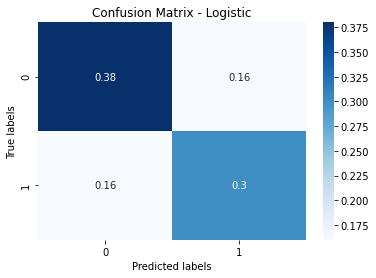

In [60]:
# 로지스틱 리그리션
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# CSV 파일 로드
df = pd.read_csv("client_scores_epoch5.csv", header=None)
print(df.columns)

# 열 이름 변경
new_columns = [f"Rank_{i+1}" for i in range(len(df.columns))]
df.columns = new_columns

# 데이터와 라벨 분리
X = df  # 첫 번째 열은 라벨이 아니므로 제외
y = [1] * 250 + [0] * 250  # 라벨 할당
print("DataFrame Rows:", len(df))
print("Labels Length:", len(y))
# 데이터를 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 초기화 및 학습
model = LogisticRegression()
model.fit(X_train, y_train)

svmreg = SVC()
svmreg.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)

svm_pred = svmreg.predict(X_test)

# 정확도 출력
print("Logistic Accuracy:", accuracy_score(y_test, y_pred))
# 정확도 계산
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(confusion_matrix(y_test, y_pred))

# 로지스틱 결과의 confusion matrix 시각화
svm_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(svm_cm*0.01, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Logistic')
plt.show()

In [31]:
X.shape

(500, 5)

[[  0.           0.70214453   1.10814135   1.35915652   1.41457951]
 [-16.94100368 -13.39400073 -13.19733866 -13.17894935 -13.02198193]
 [ -5.51157092  -5.16315518  -5.00768012  -4.89222087  -4.76732862]
 ...
 [ -6.31313011  -6.01155205  -5.90218768  -5.82402522  -5.81728741]
 [ -5.94803162  -5.93243583  -5.89034991  -5.78746285  -5.72481807]
 [-14.81323344 -14.76390425 -14.58024101 -14.51941908 -14.47213104]]


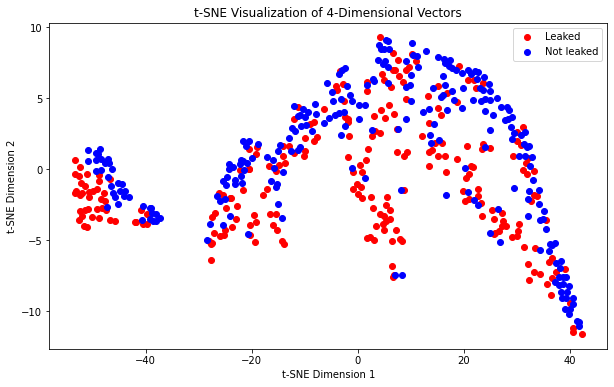

In [61]:
# t_SNE
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 유클리드 거리 계산 함수 정의
def calculate_euclidean_distances(client_file, dictionary_file):
    # 변환된 파일을 읽어옵니다.
    client_data = pd.read_csv(client_file)
    dictionary_data = pd.read_csv(dictionary_file)
    
    # 데이터 포인트 간의 유클리드 거리를 계산합니다.
    distances = euclidean_distances(client_data.values, dictionary_data.values)
    
    # top@1 score를 뺀 후 4차원 벡터화
    top1_scores = distances[:, 0]
    top5_scores = np.sort(distances, axis=1)[:, :5]
    top5_minus_top1 = top5_scores - top1_scores[:, np.newaxis]
    
    return top5_minus_top1

# 변환된 파일 경로
dictionary_file = "Dictionary_smashed_data.csv"

# t-SNE를 위한 4차원 벡터 계산
vectors_list = []
for i in range(5, 6):
    client_file = f'Client_smashed_data_epoch{i}.csv'
    vectors = calculate_euclidean_distances(client_file, dictionary_file)
    print(vectors)
    vectors_list.append(vectors)

# 리스트를 배열로 변환
vectors_array = np.concatenate(vectors_list, axis=0)

# t-SNE를 적용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
transformed_vectors = tsne.fit_transform(vectors_array)

# 첫 번째부터 250번째 벡터까지 빨간색, 이후는 파란색으로 점을 찍어 시각화
plt.figure(figsize=(10, 6))
plt.scatter(transformed_vectors[:250, 0], transformed_vectors[:250, 1], color='red', label='Leaked')
plt.scatter(transformed_vectors[250:, 0], transformed_vectors[250:, 1], color='blue', label='Not leaked')
plt.title('t-SNE Visualization of 4-Dimensional Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [93]:
vectors_array.shape

(500, 5)